In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install accelerate -U
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [3]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_metric, Dataset
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer, AutoModelForSeq2SeqLM, AutoTokenizer
nltk.download('punkt')
nltk.download('wordnet')
# nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/summary/Datasets.csv")
dataset.head()

,Task Description,Summary
0,"1. Meeting list, task list design, set their p...",describes a series of tasks related to designi...
1,1. Food app few design research.\n2. About foo...,There are many tasks related to designing and ...
2,1. Daily work update & new requirement.\n2. EB...,daily work updates and new requirements for va...
3,Absolutely! Here is a structured list of the t...,The employee's work focused primarily on commu...
4,1. Analyzing the ThriveDesk website and docume...,"analyzed and documented several websites, incl..."


In [5]:
dataset.rename(columns={'Task Description': 'dialogue', 'Summary': 'summary'}, inplace=True)
dataset.head()

,dialogue,summary
0,"1. Meeting list, task list design, set their p...",describes a series of tasks related to designi...
1,1. Food app few design research.\n2. About foo...,There are many tasks related to designing and ...
2,1. Daily work update & new requirement.\n2. EB...,daily work updates and new requirements for va...
3,Absolutely! Here is a structured list of the t...,The employee's work focused primarily on commu...
4,1. Analyzing the ThriveDesk website and docume...,"analyzed and documented several websites, incl..."


In [6]:
dataset.shape

(1044, 2)

In [7]:
def clean_and_lemmatize(text):
    # Remove digits, symbols, punctuation marks, and newline characters
    # Convert text to lowercase
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s,-]', '', text.replace('\n', ''))
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each token and join back into a sentence
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text
# Apply cleaning and lemmatization to the 'Task Description' column
dataset['dialogue'] = dataset['dialogue'].apply(clean_and_lemmatize)

In [8]:
dataset.head()

,dialogue,summary
0,"meeting list , task list design , set their po...",describes a series of tasks related to designi...
1,food app few design research about food app ne...,There are many tasks related to designing and ...
2,daily work update new requirement eb contact p...,daily work updates and new requirements for va...
3,absolutely here is a structured list of the ta...,The employee's work focused primarily on commu...
4,analyzing the thrivedesk website and documenti...,"analyzed and documented several websites, incl..."


In [9]:
# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split
train_dataset, X_temp = train_test_split(dataset, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(X_temp, test_size=0.45, random_state=42)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [12]:
dialogue_len = [len(x.split()) for x in train_dataset['dialogue']]
summary_len = [len(x.split()) for x in train_dataset['summary']]

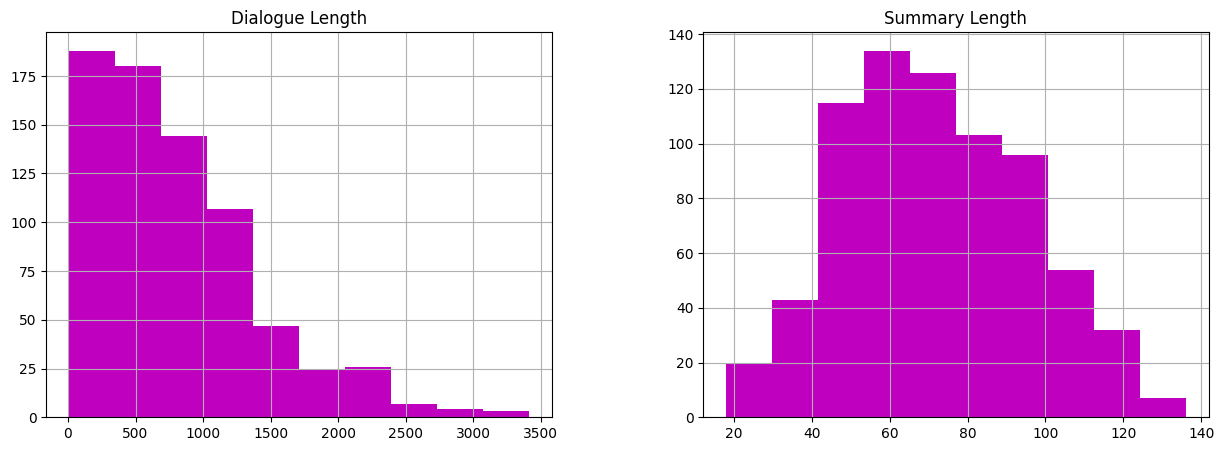

In [13]:
data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']
data.hist(figsize=(15,5), color = "m");

In [14]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [15]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [16]:
# Create a datasets.Dataset object
train_dataset = Dataset.from_dict(train_dataset)
val_dataset = Dataset.from_dict(val_dataset)
test_dataset = Dataset.from_dict(test_dataset)
# Print the dataset to check the format
print("Train Dataset : ",train_dataset)
print("Validation Dataset : ", val_dataset)
print("Test Dataset : ", test_dataset)

Train Dataset :  Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 730
})
Validation Dataset :  Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 172
})
Test Dataset :  Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 142
})


In [17]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_train = train_dataset.map(convert_examples_to_features, batched = True)
dataset_samsum_val = val_dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/730 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/172 [00:00<?, ? examples/s]

In [18]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [19]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum',
    num_train_epochs=35,
    warmup_steps=250,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=30,
    save_steps=1e6,
    gradient_accumulation_steps=4
)
trainer = Trainer(model=model_pegasus,
                  args=trainer_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_train,
                  eval_dataset=dataset_samsum_val)

trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
30,6.331500,5.498714
60,5.898900,5.118517
90,5.402600,4.769637
120,4.977100,4.473309
150,4.659000,4.249832
180,4.407800,4.065050
210,4.222800,3.913759
240,3.985000,3.789116
270,3.936200,3.661095
300,3.630800,3.551787


TrainOutput(global_step=6370, training_loss=1.6030122137144558, metrics={'train_runtime': 20334.1605, 'train_samples_per_second': 1.257, 'train_steps_per_second': 0.313, 'total_flos': 5.251660265068954e+16, 'train_loss': 1.6030122137144558, 'epoch': 34.9})

In [20]:
rouge_metric = load_metric('rouge')
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
score = calculate_metric_on_test_ds(
    test_dataset,
    rouge_metric,
    trainer.model,
    tokenizer,
    batch_size = 4,
    column_text = 'dialogue',
    column_summary= 'summary'
)
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = [f'pegasus'] )

<ipython-input-20-2bb781433832>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


100%|██████████| 36/36 [03:43<00:00,  6.22s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.612983,0.373382,0.556709,0.555538


In [21]:
## Save model
model_pegasus.save_pretrained("/content/drive/MyDrive/summary/pegasus-samsum-model")
## Save tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/summary/tokenizer")

('/content/drive/MyDrive/summary/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/summary/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/summary/tokenizer/spiece.model',
 '/content/drive/MyDrive/summary/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/summary/tokenizer/tokenizer.json')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/summary/tokenizer")
sample_text = test_dataset["dialogue"][11]
sample_text = clean_and_lemmatize(sample_text)
reference = test_dataset["summary"][11]
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}

pipe = pipeline("summarization", model="/content/drive/MyDrive/summary/pegasus-samsum-model", tokenizer=tokenizer)
print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# # !pip install accelerate -U
# !pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

import re
import nltk
from tqdm import tqdm
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer
nltk.download('punkt')
nltk.download('wordnet')

def remove_spaces_before_punctuation(text):
    pattern = re.compile(r'(\s+)([.,;!?])')
    result = pattern.sub(r'\2', text)
    return result


def clean_and_lemmatize(text):
    # Remove digits, symbols, punctuation marks, and newline characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s,-]', '', text.replace('\n', ''))
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each token and join back into a sentence
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text


tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/summary/tokenizer")
sample_text = input("\n\nGive me Your Full Month Log hour Task Description within 5500 Characters:  ")
# sample_text = test_dataset["dialogue"][3]
sample_text = clean_and_lemmatize(sample_text)
# reference = test_dataset["summary"][3]
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}

pipe = pipeline("summarization", model="/content/drive/MyDrive/summary/pegasus-samsum-model", tokenizer=tokenizer)

# Example usage
original_text = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
modified_text = remove_spaces_before_punctuation(original_text)
print("\nModel Summary: ", modified_text )